# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Enter The Frontier!

And now - we put Frontier Models to the test.

### 2 important points:

It's important to appreciate that we aren't Training the frontier models. We're only providing them with the Test dataset to see how they perform. They don't gain the benefit of the 400,000 training examples that we provided to the Traditional ML models.

HAVING SAID THAT...

It's entirely possible that in their monstrously large training data, they've already been exposed to all the products in the training AND the test set. So there could be test "contamination" here which gives them an unfair advantage. We should keep that in mind.

In [2]:
# imports

import os
import re
import math
import json
import random
from dotenv import load_dotenv
from huggingface_hub import login
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import Counter
from openai import OpenAI
from anthropic import Anthropic

In [28]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY', 'your-key-if-not-using-env')
Google_API_KEY = os.environ['GOOGLE_API_KEY']
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [4]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [5]:
# moved our Tester into a separate package
# call it with Tester.test(function_name, test_dataset)

from items import Item
from testing import Tester

In [6]:
openai = OpenAI()
claude = Anthropic()

In [7]:
%matplotlib inline

In [8]:
# Let's avoid curating all our data again! Load in the pickle files:

with open('train.pkl', 'rb') as file:
    train = pickle.load(file)

with open('test.pkl', 'rb') as file:
    test = pickle.load(file)

# Before we look at the Frontier

## There is one more model we could consider

In [9]:
# Write the test set to a CSV

import csv
with open('human_input.csv', 'w', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    for t in test[:250]:
        writer.writerow([t.test_prompt(), 0])

In [10]:
# Read it back in

human_predictions = []
with open('human_output.csv', 'r', encoding="utf-8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        human_predictions.append(float(row[1]))

In [11]:
def human_pricer(item):
    idx = test.index(item)
    return human_predictions[idx]

1: Guess: $120.00 Truth: $385.97 Error: $265.97 SLE: 1.35 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $80.00 Truth: $277.91 Error: $197.91 SLE: 1.53 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $35.00 Truth: $147.33 Error: $112.33 SLE: 2.00 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $350.00 Truth: $74.99 Error: $275.01 SLE: 2.34 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $75.00 Truth: $19.99 Error: $55.01 SLE: 1.66 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $12.00 Truth: $166.60 Error: $154.60 SLE: 6.54 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $115.00 Truth: $265.00 Error: $150.00 SLE: 0.69 Item: Nest Cam IQ, Works with Alexa
8: Guess: $100.00 Truth: $165.99 Error: $65.99 SLE: 0.25 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $300.00 Truth: $69.99 Error: $230.01 SLE: 2.09 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $80.00 Truth: $319.59 Error: $239.59 SLE

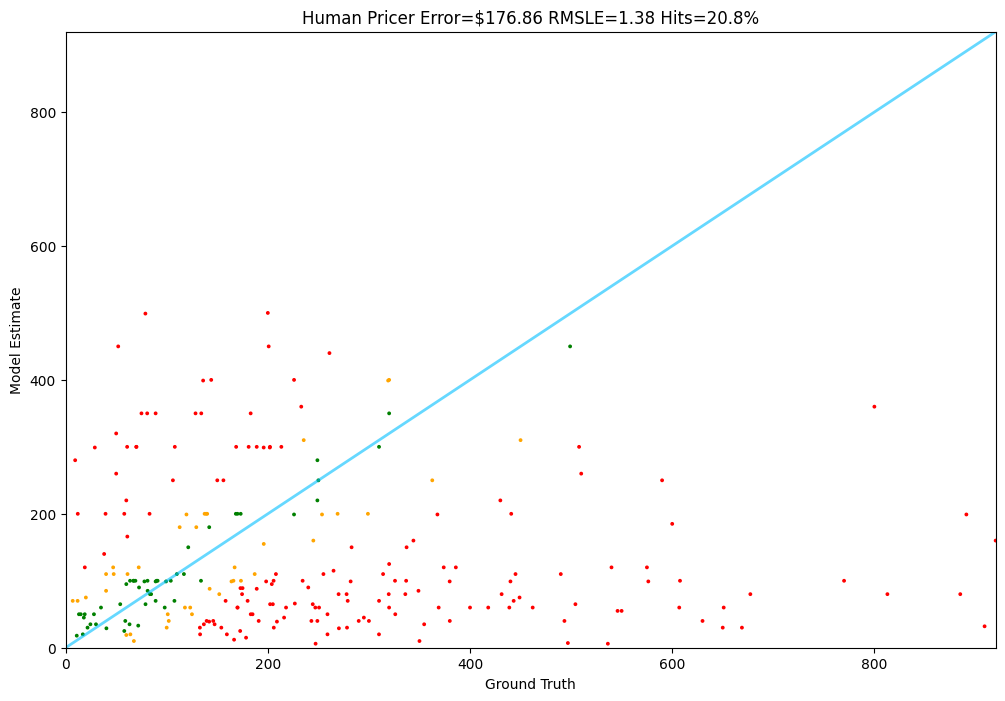

In [12]:
Tester.test(human_pricer, test)

## First, the humble but mighty GPT-4o-mini

It's called mini, but it packs a punch.

In [13]:
# First let's work on a good prompt for a Frontier model
# Notice that I'm removing the " to the nearest dollar"
# When we train our own models, we'll need to make the problem as easy as possible, 
# but a Frontier model needs no such simplification.

def messages_for(item):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

In [14]:
# Try this out

messages_for(test[0])

[{'role': 'system',
  'content': 'You estimate prices of items. Reply only with the price, no explanation'},
 {'role': 'user',
  'content': 'How much does this cost?\n\nTeco 2 HP, 3600 RPM, TEFC, 145T Frame, Volt, 3 PH, Max-Pe, Footed Frame AC Electric Induction Motor\nTECO WESTINGHOUSE MAX-PE PREMIUM EFFICIENCY TEFC INVERTER DUTY MOTOR 2HP, 3600 RPM, 145T, NP0022 TECO WESTINGHOUSE MAX-PE PREMIUM EFFICIENCY TEFC INVERTER DUTY MOTOR 2HP, 3600 RPM, 145T, NP0022 62.0 LBR Brand Teco Westinghouse, Speed 3600 RPM, Horsepower 2 hp, Weight 62 Pounds, Available October 26, 2016, Manufacturer TECO WESTINGHOUSE'},
 {'role': 'assistant', 'content': 'Price is $'}]

In [15]:
# A utility function to extract the price from a string

def get_price(s):
    s = s.replace('$','').replace(',','')
    match = re.search(r"[-+]?\d*\.\d+|\d+", s)
    return float(match.group()) if match else 0

In [34]:
get_price("The price is roughly $99.99 because blah blah")

99.99

In [35]:
from openai import OpenAI
import time

# Create a client using your Gemini API key
client = OpenAI(api_key=Google_API_KEY, base_url="https://generativelanguage.googleapis.com/v1beta/openai/")

def gemini_flash(item):
    response = client.chat.completions.create(
        model="gemini-2.5-flash",
        messages=messages_for(item),
        max_tokens=5
    )
    reply = response.choices[0].message.content
    time.sleep(6)
    return get_price(reply)


In [36]:
test[0].price

385.97

In [37]:
Tester.test(gemini_flash, test)

1: Guess: $550.00 Truth: $385.97 Error: $164.03 SLE: 0.12 Item: Teco NP0022, 2 HP, 3600 RPM, TEFC, 145T ...
2: Guess: $150.00 Truth: $277.91 Error: $127.91 SLE: 0.38 Item: hansgrohe Metris Modern Upgrade Easy Ins...
3: Guess: $89.99 Truth: $147.33 Error: $57.34 SLE: 0.24 Item: Shoxtec Front Pair Complete Strut Assemb...
4: Guess: $18.27 Truth: $74.99 Error: $56.72 SLE: 1.88 Item: Depo 373-2009R-AS Replacement Passenger ...
5: Guess: $19.00 Truth: $19.99 Error: $0.99 SLE: 0.00 Item: Cnuben Coffee Dripper Cone,Without Filte...
6: Guess: $199.90 Truth: $166.60 Error: $33.30 SLE: 0.03 Item: Worth-Mats 3D Full Coverage Car Trunk Ma...
7: Guess: $299.00 Truth: $265.00 Error: $34.00 SLE: 0.01 Item: Nest Cam IQ, Works with Alexa
8: Guess: $300.00 Truth: $165.99 Error: $134.01 SLE: 0.35 Item: High Temperature Oval Ceramic Bathroom S...
9: Guess: $150.00 Truth: $69.99 Error: $80.01 SLE: 0.57 Item: Sky Designer 2 Packs 1 Light Modern K9 P...
10: Guess: $217.00 Truth: $319.59 Error: $102.59 SLE: 0

RateLimitError: Error code: 429 - [{'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '250'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '37s'}]}}]

In [ ]:
from openai import OpenAI
import time

# Create a client using your Gemini API key
client = OpenAI(api_key=Google_API_KEY, base_url="https://generativelanguage.googleapis.com/v1beta/openai/")

def gemini_flash_pro(item):
    response = client.chat.completions.create(
        model="gemini-2.5-pro",
        messages=messages_for(item),
        max_tokens=5
    )
    reply = response.choices[0].message.content
    time.sleep(12)
    return get_price(reply)


In [ ]:
Tester.test(gemini_flash_pro, test)